# Credit Risk Modelling

This Jupyter Notebook Focuses on calculation of the expected loss based on given data on customer loan data.


In [1]:
import pandas as pd
from pathlib import Path
import numpy as np

In [2]:
csv_path = Path.home() /"downloads"/ "loan_data.csv"
loan_df = pd.read_csv(csv_path)
loan_df

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0
...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,697,0
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,615,0
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,596,0
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,647,0


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
#Split data into features and target
x = loan_df.drop(['default', 'customer_id'], axis = 1) # Features
y = loan_df['default'] # Target
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

#Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.25, random_state=42)

#Initialize Model
log_reg = LogisticRegression()

#Train Model
log_reg.fit(X_train,y_train)

#Predict probabilities
prob = log_reg.predict_proba(X_test)[:, 1]
prob

array([5.90615317e-08, 9.55895715e-03, 9.99999948e-01, ...,
       1.93024405e-09, 9.99969153e-01, 9.22749824e-10])

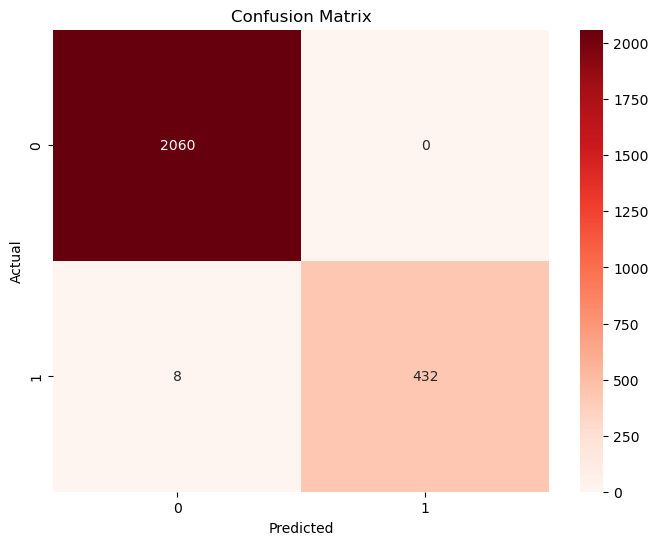

In [4]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = log_reg.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='g',cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [5]:
def calculate_expected_loss(model, scaler, features, recovery_rate = 0.1):
    features_scaled = scaler.transform([features])

    pr_of_default = model.predict_proba(features_scaled)[:, 1][0] #Used a log regression to predict probability of default
    LGD = 1 - recovery_rate #Loss given default
    EAD = features[1] # Exposure at default. Just the loan_amt_outstanding.

    expected_loss = pr_of_default * LGD * EAD
    return expected_loss

In [6]:
feature_names = x.columns

coeffs = log_reg.coef_[0]

coeff_df = pd.DataFrame({'Feature' : feature_names, 'Coefficient':coeffs})

coeff_df.sort_values(by = 'Coefficient')

,Feature,Coefficient
4,years_employed,-2.813901
3,income,-2.447822
5,fico_score,-1.176105
1,loan_amt_outstanding,0.217549
2,total_debt_outstanding,3.765139
0,credit_lines_outstanding,8.693588


In [7]:
from scipy.stats import binom 


In [8]:
num_buckets = 4
loan_df['buckets'] = pd.cut(loan_df['fico_score'], bins = num_buckets, labels = False)
loan_df

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default,buckets
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0,1
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0,1
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0,1
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0,2
...,...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,697,0,2
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,615,0,1
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,596,0,1
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,647,0,2


In [9]:
def calc_log_likelihood(data):
    log_likelihood = 0
    for b in range(num_buckets):
        bucket_data = loan_df[loan_df['buckets'] == b]
        if not bucket_data.empty:
            n_i = len(bucket_data)
            k_i = bucket_data['default'].sum()
            p_i = k_i/n_i if n_i > 0 else 0
            log_likelihood += binom.logpmf(k_i,n_i,p_i)
        return log_likelihood

initial_log_likelihood = calc_log_likelihood(loan_df)

print(f"Initial Log Likelihood: {initial_log_likelihood}")


Initial Log Likelihood: -2.994962709380985


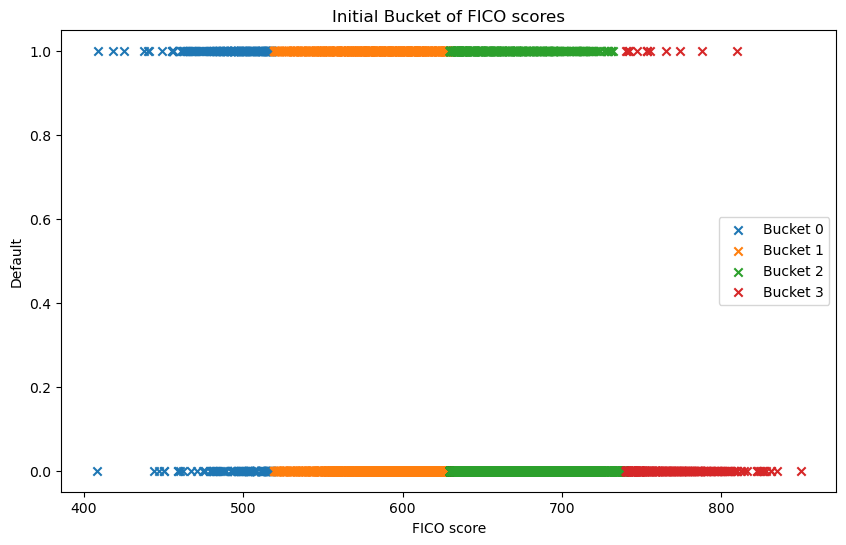

In [10]:
plt.figure(figsize=(10,6))
for b in range(num_buckets):
    bucket_data = loan_df[loan_df['buckets'] == b]
    plt.scatter(bucket_data['fico_score'], bucket_data['default'], label = f"Bucket {b}", marker = 'x')
plt.xlabel('FICO score')
plt.ylabel('Default')
plt.legend()
plt.title('Initial Bucket of FICO scores')
plt.show()

In [13]:
def optimise_buckets(data, num_buckets, max_iterations = 100):
    boundaries = np.linspace(loan_df['fico_score'].min(), loan_df['fico_score'].max(), num_buckets + 1)
    best_likelihood = calc_log_likelihood(data)
    improved = True
    iterations = 0

    while improved and iterations < max_iterations:
        improved = False
        for i in range(1, len(boundaries) - 1):
            original_boundary = boundaries[i]
            for shift in [-10,10]:
                boundaries[i] += shift
                loan_df['buckets'] = pd.cut(loan_df['fico_score'], bins = boundaries, labels = False, include_lowest = True)
                new_likelihood = calc_log_likelihood(data)
                if new_likelihood > best_likelihood:
                    best_likelihood = new_likelihood
                    improved = True
                else:
                    boundaries[i] = original_boundary

        iterations += 1
        print(f"iteration: {iterations}, log likelihood: {best_likelihood}")
    return boundaries
        
                    
            

In [14]:
final_boundaries = optimise_buckets(loan_df, num_buckets)
loan_df['buckets'] = pd.cut(loan_df['fico_score'], bins = final_boundaries , labels = False, include_lowest = True)
final_boundaries

iteration: 1, log likelihood: -2.8243592225420286
iteration: 2, log likelihood: -2.8243592225420286


array([408. , 518.5, 629. , 739.5, 850. ])